In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import numpy as np
import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
gc.collect()


0

In [23]:
input_path = r'C:\Users\admin\OneDrive\anaconda\UnetData\data' #数据所在文件路径
#存储图像的文件名列表
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]
width = 284 
height = 284
width_out = 196
height_out = 196


In [24]:
mat = scipy.io.loadmat(subject_path[0])
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']
img_array = np.transpose(img_tensor, (2, 0, 1)) #img_tensor按照列2，0，1的顺序
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

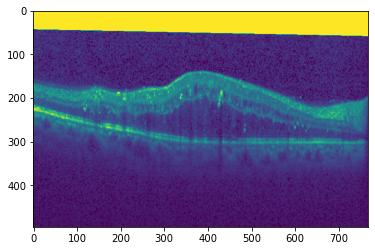

In [25]:
plt.imshow(img_array[25])

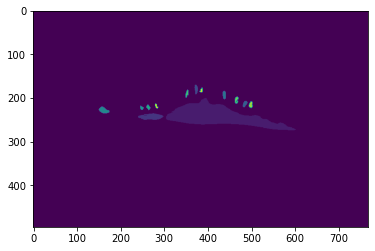

In [26]:
plt.imshow(manual_fluid_array[25])

In [6]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes=[np.float])#将函数向量化


<ipython-input-6-f831376adf9e>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  thresh = np.vectorize(thresh, otypes=[np.float])#将函数向量化


In [7]:
def create_dataset(paths):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        #print('img_array.shape[0]==',img_array.shape[0])
        img_array = resize(img_array, (img_array.shape[0], width, height))
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        #print('fluid_array.shape[0]==',fluid_array.shape[0])
        fluid_array  = resize(fluid_array, (fluid_array.shape[0], width_out, height_out))

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)] #img_array增加一个维度
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(subject_path[:9])#训练集：Subject_01.mat~Subject_09.mat
x_val, y_val = create_dataset(subject_path[9:])#测试集：Subject_10.mat

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.10s/it]


In [8]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 1, 284, 284), (99, 1, 196, 196), (11, 1, 284, 284), (11, 1, 196, 196))

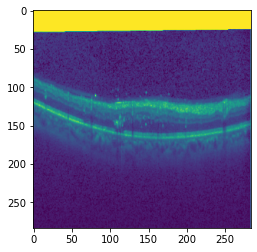

In [9]:
plt.imshow(x_train[0][0])


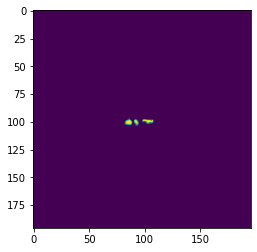

In [10]:
plt.imshow(y_train[0][0])

In [11]:
use_gpu = torch.cuda.is_available() #GPU是否可用
batch_size = 9 #块大小
epochs = 30 #训练轮数
epoch_lapse = 10
threshold = 0.5
sample_size = None

In [18]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):#收缩路径（左边），由两个重复的3*3卷积核组成，且均使用修正线性
                                                                          #单元Relu激活函数
        block = torch.nn.Sequential(                                      
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),#卷积层
                    torch.nn.ReLU(),#激励层
                    torch.nn.BatchNorm2d(out_channels),#归一化处理
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):#扩张路径（右边），每一步都包含对特征图进行上采样，然后用2*2的卷积核进行
            block = torch.nn.Sequential(                                             #进行卷积运算（上卷积），用于减少一半的特征通道数量；再用两个3*3的卷积核进行卷积运算
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )#反卷积函数，通过卷积的形式，利用图像特征“恢复”到原图像，即上卷积
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):#最后一层，用1*1的卷积核进行卷积运算，将每个64维的特征向量映射网络的输出层
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)#和一个用于下采样的步长为2的2*2最大池化操作，在每个下采样步骤中，
                                                              #我们将特征频道的数量加倍
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        ##print(x.shape, encode_block1.shape, encode_block2.shape, encode_block3.shape, bottleneck1.shape)
        ##print('Decode Block 3')
        ##print(bottleneck1.shape, encode_block3.shape)
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        ##print(decode_block3.shape)
        ##print('Decode Block 2')
        cat_layer2 = self.conv_decode3(decode_block3)
        ##print(cat_layer2.shape, encode_block2.shape)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        ##print(cat_layer1.shape, encode_block1.shape)
        ##print('Final Layer')
        ##print(cat_layer1.shape, encode_block1.shape)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        ##print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        ##print(final_layer.shape)
        return  final_layer
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad() #模型中的梯度设为0
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1) #将tensor换维
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)
    labels = labels.resize(batch_size*width_out*height_out)
    loss = criterion(outputs, labels) #将预测值和实际值（实际的标签）作为损失函数的输入得到损失
    loss.backward()
    optimizer.step()
    return loss

In [19]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad() #梯度设为0
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1) #将tensor换维
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)
    labels = labels.resize(batch_size*width_out*height_out)
    loss = criterion(outputs, labels) #将预测值和实际值（实际的标签）作为损失函数的输入得到损失
    loss.backward()
    optimizer.step()
    return loss

In [20]:
learning_rate = 0.01 #学习率
unet = UNet(in_channel=1,out_channel=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss() #交叉熵损失函数
optimizer = optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99) #优化方法为随机梯度下降

In [21]:
def get_val_loss(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1) #将tensor的维度换位
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)#使神经网络学习更快
    return loss.data

In [22]:
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
t = trange(epochs, leave=True)
for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        unet.train()
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()#返回的张量和ndarray共享同一内存。对张量的修改将反映在ndarray中，反之亦然。返回的张量是不能调整大小的
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
        total_loss += batch_loss
    if (_+1) % epoch_lapse == 0:
        unet.eval()
        val_loss = get_val_loss(x_val, y_val)
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")
        

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\Users\admin\.conda\envs\pytorch\lib\site-packages\torch\tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 33%|██████████████████████████▎                                                    | 10/30 [41:45<1:23:11, 249.59s/it]

Total loss in epoch 10 : 0.6827433109283447 and validation loss : 0.5110440850257874


 67%|████████████████████████████████████████████████████▋                          | 20/30 [1:23:42<42:10, 253.05s/it]

Total loss in epoch 20 : 0.6782346367835999 and validation loss : 0.4614056348800659


100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [2:01:48<00:00, 243.60s/it]

Total loss in epoch 30 : 0.6720935702323914 and validation loss : 0.4977164566516876


In [ ]:
gc.collect()

In [ ]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

In [ ]:
plot_examples(x_train, y_train)

In [ ]:
plot_examples(x_val, y_val)

In [ ]:
torch.save(unet.state_dict(), 'unet.pt')